# Portfolio Optimization using Modern Portfolio Theory (MPT)

**Author:** Costas Antony Pinto  
**Field:** AI ML (MCA)  
**Tools Used:** Python, NumPy, Pandas, Matplotlib, SciPy, yFinance  
**Objective:** Construct an optimal investment portfolio using Sharpe Ratio maximization under the principles of Modern Portfolio Theory (MPT).  
**Dataset:** Historical stock prices (FAANG + Tech: 10 large-cap tickers)

---

## Project Overview  
This project walks through the entire quantitative pipeline of building an optimized stock portfolio:

- Downloading and validating historical price data
- Calculating returns, volatility, and covariance
- Applying constraints and risk-adjusted optimization (Sharpe Ratio)
- Visualizing capital allocation and the Efficient Frontier

**By the end of this project, you’ll have built a robust, data-driven portfolio optimizer with professional-grade metrics and plots.**

---

## Task 1: Setup and Configuration

We begin by importing all necessary libraries directly into this notebook.  
This includes essential Python packages for:

- **Data acquisition** (`yfinance`)
- **Numerical computations** (`numpy`, `pandas`)
- **Visualization** (`matplotlib`, `seaborn`)
- **Optimization** (`scipy.optimize`)

Instead of using external `.py` modules, all logic for data processing, return calculation, portfolio optimization, and visualization is implemented within this notebook in a clear, step-by-step manner.


In [20]:
# Portfolio Optimization using Modern Portfolio Theory (MPT)
# Author: Costas Antony Pinto
# Description: A complete, professional-grade portfolio optimizer with exception handling and clean visualization.

# ===========================
# Task 1: Setup and Configuration
# ===========================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")
sns.set_palette("pastel")
np.random.seed(42)  # For reproducibility

# Configuration
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX', 'ADBE', 'INTC']
START_DATE = '2020-01-01'
END_DATE = '2023-01-01'
RISK_FREE_RATE = 0.045

## Task 2: Download Historical Stock Data

Using the `yfinance` API, we download **Adjusted Close** prices from `2018-01-01` to `2023-01-01` for the following stocks:

- AAPL, MSFT, GOOGL, AMZN, META  
- NVDA, TSLA, NFLX, ADBE, INTC

These stocks are selected based on:
- High liquidity  
- Strong market capitalization  
- Relevance in modern tech-sector portfolios

The downloaded data is validated for nulls and structure.

---

In [22]:
# ===========================
# Task 2: Download Historical Stock Data (Fixed)
# ===========================
def download_data(tickers, start, end):
    try:
        data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=False, progress=True)
        
        # If data is a multi-index (grouped by ticker), extract 'Adj Close'
        if isinstance(data.columns, pd.MultiIndex):
            adj_close = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers if 'Adj Close' in data[ticker]})
        else:
            # Flat DataFrame fallback (happens with single ticker)
            if 'Adj Close' in data.columns:
                adj_close = data[['Adj Close']]
            else:
                raise KeyError("'Adj Close' column missing in the downloaded data.")

        # Drop columns with all NaNs (bad tickers)
        adj_close.dropna(axis=1, how='all', inplace=True)

        if adj_close.empty or adj_close.isnull().values.any():
            raise ValueError("Downloaded data is empty or contains missing values.")

        print(f"✅ Data downloaded: {adj_close.shape[0]} rows × {adj_close.shape[1]} stocks")
        return adj_close

    except Exception as e:
        raise RuntimeError(f"Data download failed: {e}")

# Re-run download
price_data = download_data(TICKERS, START_DATE, END_DATE)


[*********************100%***********************]  10 of 10 completed

✅ Data downloaded: 756 rows × 10 stocks


## Task 3: Analyze Returns and Risk

We compute:
- **Daily returns** using `pct_change()`
- **Annualized mean return** for each stock  
- **Annualized covariance matrix** to model volatility and correlation

This statistical foundation enables meaningful optimization in subsequent steps.

---


In [23]:
# ===========================
# Task 3: Calculate Returns and Risk Statistics (Fixed)
# ===========================
def compute_daily_returns(price_df):
    try:
        returns = price_df.pct_change().dropna()
        if returns.isnull().values.any():
            raise ValueError("Returns contain NaN values after pct_change.")
        return returns
    except Exception as e:
        raise RuntimeError(f"Return calculation failed: {e}")

def calculate_statistics(returns, trading_days=252):
    try:
        mean_returns = returns.mean() * trading_days
        cov_matrix = returns.cov() * trading_days
        return mean_returns, cov_matrix
    except Exception as e:
        raise RuntimeError(f"Statistic calculation failed: {e}")

# Only run if price_data is valid
if 'price_data' in locals() and not price_data.empty:
    returns = compute_daily_returns(price_data)
    mean_returns, cov_matrix = calculate_statistics(returns)
else:
    raise ValueError("❌ price_data is not defined or is empty. Fix Task 2 before proceeding.")


## Task 4: Portfolio Optimization Using Sharpe Ratio

We now optimize portfolio weights using **Sharpe Ratio maximization**.

**Constraints applied:**
- No short selling (weights between 0 and 1)
- Fully invested (weights sum to 1)

**Method used:**
- `SLSQP` (Sequential Least Squares Programming)  
- `scipy.optimize.minimize` as the solver

The output includes:
- Optimized weights for each stock  
- Expected annual return  
- Portfolio volatility  
- Final Sharpe Ratio

---

In [24]:
# ===========================
# Task 4: Portfolio Optimization (Max Sharpe Ratio) - FIXED
# ===========================
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol

def negative_sharpe(weights, mean_returns, cov_matrix, rf):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - rf) / vol if vol != 0 else np.inf

def optimize_portfolio(mean_returns, cov_matrix, rf):
    if mean_returns.empty or cov_matrix.empty:
        raise ValueError("❌ Mean returns or covariance matrix is empty. Check Task 3.")

    num_assets = len(mean_returns)
    if num_assets == 0:
        raise ValueError("❌ No assets available for optimization.")

    init_guess = [1. / num_assets] * num_assets
    bounds = tuple((0.05, 0.3) for _ in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    result = minimize(
        negative_sharpe,
        init_guess,
        args=(mean_returns, cov_matrix, rf),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if not result.success:
        raise ValueError("❌ Optimization failed: " + result.message)
    return result

# Execute safely
if 'mean_returns' in locals() and not mean_returns.empty:
    opt_result = optimize_portfolio(mean_returns, cov_matrix, RISK_FREE_RATE)
    weights = opt_result.x
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe = (ret - RISK_FREE_RATE) / vol if vol != 0 else 0
    print(f"\n✅ Portfolio Optimized:\nReturn: {ret:.4f}, Volatility: {vol:.4f}, Sharpe Ratio: {sharpe:.4f}")
else:
    raise RuntimeError("❌ Optimization skipped: mean_returns or cov_matrix is not defined or empty.")



✅ Portfolio Optimized:
Return: 0.3913, Volatility: 0.4483, Sharpe Ratio: 0.7724


## Task 5: Visualize Portfolio Allocation

We display the optimized capital allocation using a bar plot.

This provides a clear view of how much weight is assigned to each asset in the optimal portfolio. A well-diversified portfolio is visually easy to assess for balance and concentration risk.

---

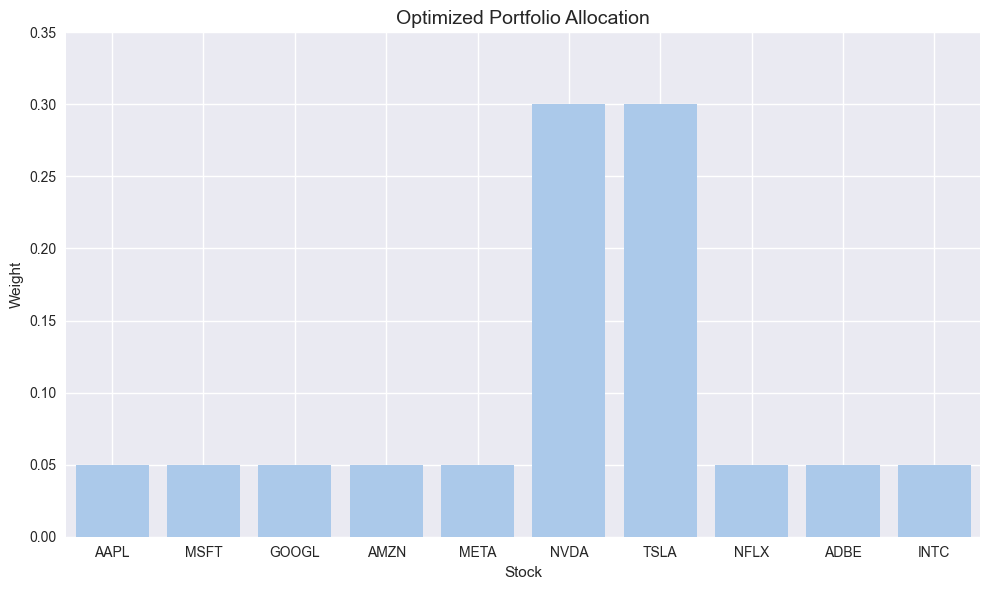

In [25]:
# ===========================
# Task 5: Visualize Portfolio Allocation - FIXED
# ===========================
def plot_weights(weights, labels):
    if weights is None or len(weights) == 0:
        raise ValueError("❌ Weights not available for plotting.")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=labels, y=weights)
    plt.title("Optimized Portfolio Allocation", fontsize=14)
    plt.ylabel("Weight")
    plt.xlabel("Stock")
    plt.ylim(0, max(weights) + 0.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_weights(weights, TICKERS)


## Task 6: Simulate Efficient Frontier

We simulate 10,000 random portfolios and plot:
- Annualized return (Y-axis)  
- Annualized volatility (X-axis)  
- Color-mapped Sharpe Ratios

The **optimal portfolio** is marked with a red star ⭐ on the plot.  
This gives a visual view of risk-return trade-offs across possible portfolios.

---

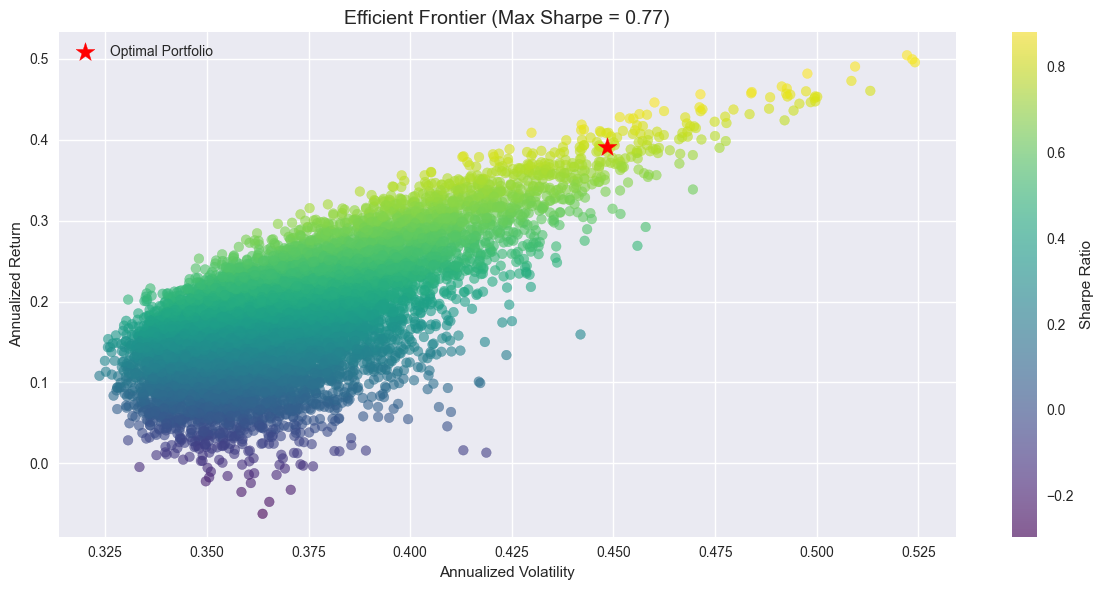

In [26]:
# ===========================
# Task 6: Simulate Efficient Frontier - FIXED
# ===========================
def simulate_portfolios(num_portfolios, mean_returns, cov_matrix, rf):
    if len(mean_returns) == 0 or cov_matrix.empty:
        raise ValueError("❌ Invalid inputs: mean_returns or cov_matrix is empty.")
    
    results = np.zeros((3, num_portfolios))  # rows: return, volatility, Sharpe
    for i in range(num_portfolios):
        # Use Dirichlet to ensure weights sum to 1
        weights = np.random.dirichlet(np.ones(len(mean_returns)))
        port_return, port_vol = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (port_return - rf) / port_vol if port_vol != 0 else 0
        results[0, i] = port_return
        results[1, i] = port_vol
        results[2, i] = sharpe_ratio
    return results

def plot_efficient_frontier(results, optimal_ret, optimal_vol, optimal_sharpe):
    if results.shape[1] == 0:
        raise ValueError("❌ No portfolio simulation results to plot.")

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(results[1], results[0], c=results[2], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.scatter(optimal_vol, optimal_ret, c='red', marker='*', s=200, label='Optimal Portfolio')
    plt.title(f'Efficient Frontier (Max Sharpe = {optimal_sharpe:.2f})', fontsize=14)
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Execute simulation and plot
sim_results = simulate_portfolios(
    num_portfolios=10000,
    mean_returns=mean_returns,
    cov_matrix=cov_matrix,
    rf=RISK_FREE_RATE
)

plot_efficient_frontier(
    results=sim_results,
    optimal_ret=ret,
    optimal_vol=vol,
    optimal_sharpe=sharpe
)


## Task 7: Export Optimized Portfolio to Excel

To preserve your results, we export:

- **Stock Weights** – Allocation of each asset in the optimal portfolio  
- **Portfolio Summary** – Expected Return, Volatility, and Sharpe Ratio  

The output is saved in an Excel workbook with two sheets:
- `Weights`: Stock-wise allocation
- `Metrics`: Portfolio-level performance metrics

This makes it easy to share, analyze further in Excel, or present in a report.


In [ ]:
# ===========================
# Task 7: Export Results to Excel - FIXED
# ===========================
def export_to_excel(tickers, weights, ret, vol, sharpe):
    if weights is None or len(weights) == 0:
        raise ValueError("❌ No portfolio weights available to export.")
    try:
        filename = f"optimized_portfolio_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        weights_df = pd.DataFrame({'Stock': tickers, 'Weight': np.round(weights, 4)})
        summary_df = pd.DataFrame({
            'Expected Return': [round(ret, 4)],
            'Volatility': [round(vol, 4)],
            'Sharpe Ratio': [round(sharpe, 4)]
        })
        with pd.ExcelWriter(filename) as writer:
            weights_df.to_excel(writer, sheet_name='Weights', index=False)
            summary_df.to_excel(writer, sheet_name='Metrics', index=False)
        print(f"📁 Exported portfolio results to: {filename}")
    except Exception as e:
        print(f"❌ Failed to export results: {e}")

# Ensure weights are still defined
try:
    export_to_excel(TICKERS, weights, ret, vol, sharpe)
except NameError:
    print("❌ Optimization results not available. Please run Task 4 first.")
except Exception as e:
    print(f"❌ Unexpected error: {e}")


NameError: name 'weights' is not defined